In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [2]:
# Load npy file
path = '/content/drive/MyDrive'
swarm_chroma = np.load(path + '/swarm_chroma.npy')
no_swarm_chroma = np.load(path + '/no_swarm_chroma.npy')
prep_chroma = np.load(path + '/prep_chroma.npy')

print(swarm_chroma.shape)
print(no_swarm_chroma.shape)
print(prep_chroma.shape)

(14000, 12, 173)
(14000, 12, 173)
(14000, 12, 173)


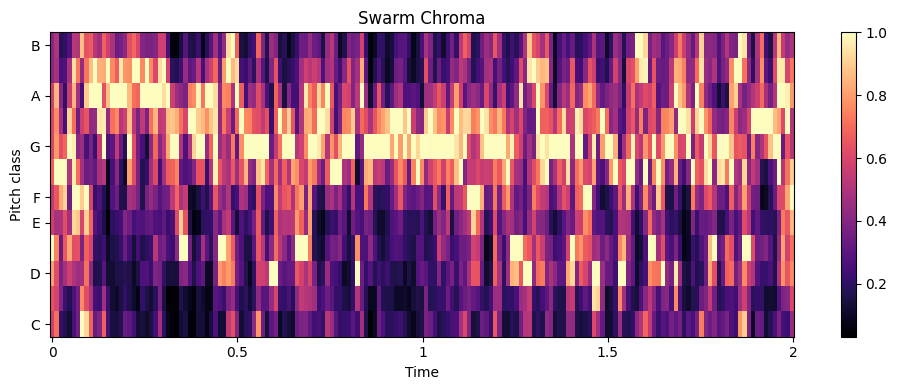

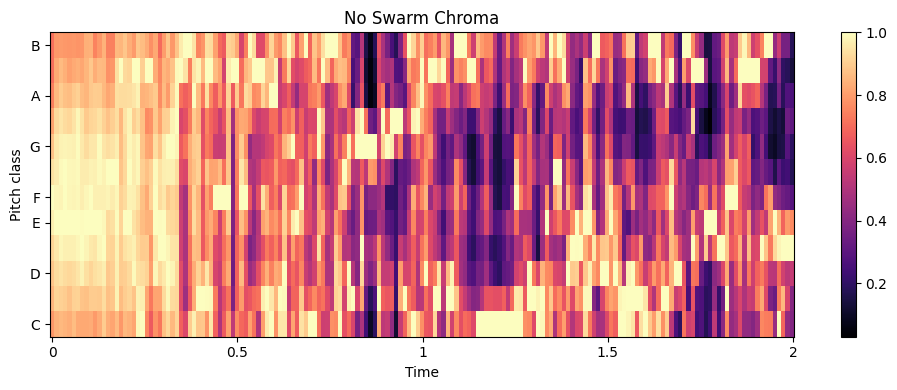

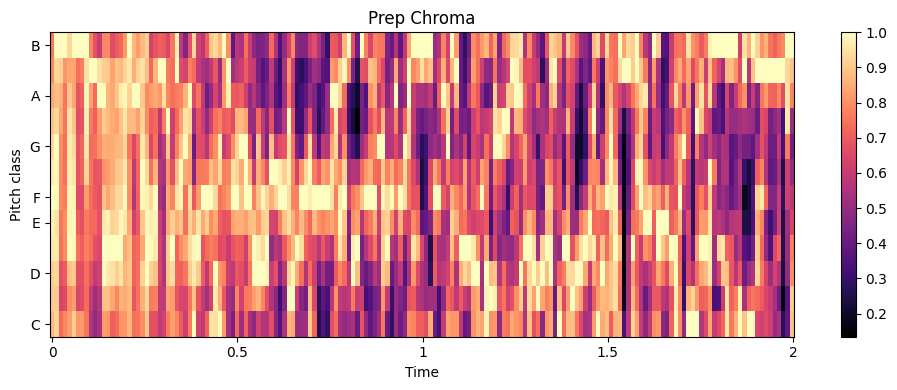

In [3]:
# Visualize Chroma
plt.figure(figsize=(10, 4))
librosa.display.specshow(swarm_chroma[0], sr=44100, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Swarm Chroma')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
librosa.display.specshow(no_swarm_chroma[0], sr=44100, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('No Swarm Chroma')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
librosa.display.specshow(prep_chroma[0], sr=44100, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Prep Chroma')
plt.tight_layout()
plt.show()

# Build Model

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## Data Split

In [5]:
# X is the feature set, y is the label set (swarm: 1, no_swarm: 0, prep: -1)
X = np.concatenate((swarm_chroma, no_swarm_chroma, prep_chroma), axis=0)
y = np.concatenate((np.ones(len(swarm_chroma)), np.zeros(len(no_swarm_chroma)), -np.ones(len(prep_chroma))), axis=0)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

print(X_train.shape, X_test.shape, X_val.shape)

# Distribution of each class in train, test, and val (percentages)
print('X_train swarm:', np.sum(y_train == 1) / len(y_train))
print('X_train no_swarm:', np.sum(y_train == 0) / len(y_train))
print('X_train prep:', np.sum(y_train == -1) / len(y_train))

print('X_test swarm:', np.sum(y_test == 1) / len(y_test))
print('X_test no_swarm:', np.sum(y_test == 0) / len(y_test))
print('X_test prep:', np.sum(y_test == -1) / len(y_test))

print('X_val swarm:', np.sum(y_val == 1) / len(y_val))
print('X_val no_swarm:', np.sum(y_val == 0) / len(y_val))
print('X_val prep:', np.sum(y_val == -1) / len(y_val))

(23205, 12, 173) (14700, 12, 173) (4095, 12, 173)
X_train swarm: 0.3333333333333333
X_train no_swarm: 0.3333333333333333
X_train prep: 0.3333333333333333
X_test swarm: 0.3333333333333333
X_test no_swarm: 0.3333333333333333
X_test prep: 0.3333333333333333
X_val swarm: 0.3333333333333333
X_val no_swarm: 0.3333333333333333
X_val prep: 0.3333333333333333


In [7]:
X_train.shape, X_test.shape, X_val.shape

((23205, 12, 173), (14700, 12, 173), (4095, 12, 173))

## Encode Labels

In [8]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [9]:
y_train.shape, y_test.shape, y_val.shape

((23205, 3), (14700, 3), (4095, 3))

## Build Model

In [10]:
lr = 0.001
epochs = 100
batch_size = 128

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 173, 256)      2560      
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 86, 256)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 86, 128)        295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 43, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 43, 128)        147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 21, 128)        0

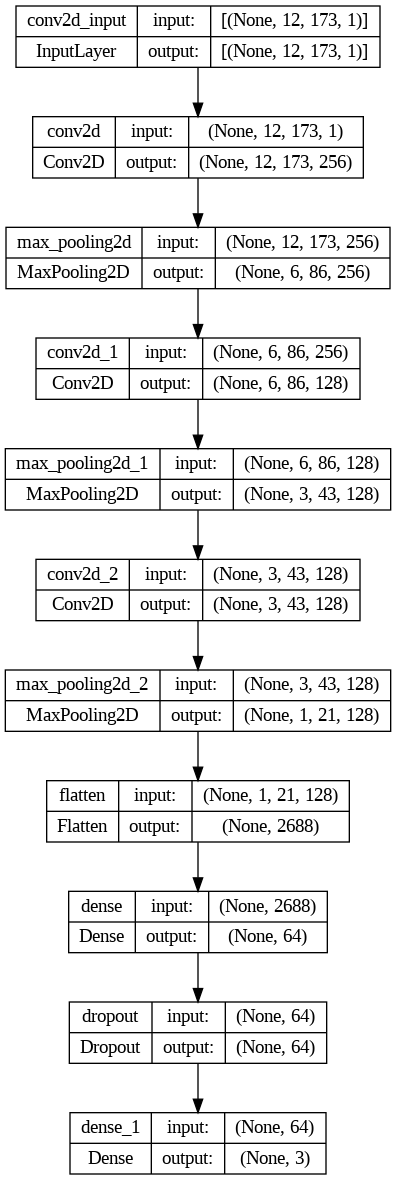

In [11]:
model = Sequential()
model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1), padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

model.summary()

plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    validation_batch_size=batch_size,
                    callbacks=[es], verbose=1)

model.evaluate(X_test, y_test)

Epoch 1/100
182/182 [==============================] - 26s 61ms/step - loss: 0.4247 - accuracy: 0.8280 - val_loss: 0.1505 - val_accuracy: 0.9529
Epoch 2/100
182/182 [==============================] - 8s 44ms/step - loss: 0.1649 - accuracy: 0.9530 - val_loss: 0.0982 - val_accuracy: 0.9690
Epoch 3/100
182/182 [==============================] - 8s 43ms/step - loss: 0.1257 - accuracy: 0.9622 - val_loss: 0.0865 - val_accuracy: 0.9697
Epoch 4/100
182/182 [==============================] - 8s 46ms/step - loss: 0.0988 - accuracy: 0.9716 - val_loss: 0.0753 - val_accuracy: 0.9770
Epoch 5/100
182/182 [==============================] - 8s 42ms/step - loss: 0.0779 - accuracy: 0.9769 - val_loss: 0.0804 - val_accuracy: 0.9763
Epoch 6/100
182/182 [==============================] - 7s 41ms/step - loss: 0.0704 - accuracy: 0.9787 - val_loss: 0.0490 - val_accuracy: 0.9839
Epoch 7/100
182/182 [==============================] - 8s 43ms/step - loss: 0.0601 - accuracy: 0.9827 - val_loss: 0.0841 - val_accuracy

[0.025806179270148277, 0.9939455986022949]

In [13]:
# Evaluate on test
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

print(accuracy)

460/460 [==============================] - 2s 4ms/step
0.9939455782312925


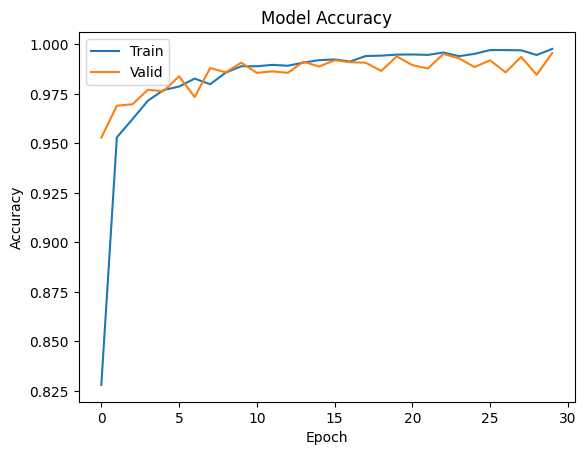

In [14]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

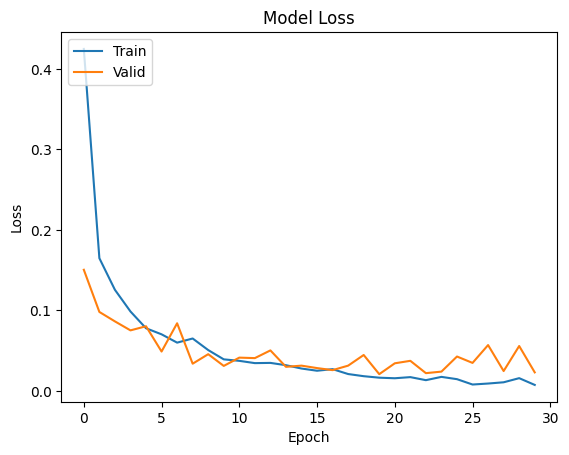

In [15]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

460/460 [==============================] - 2s 4ms/step


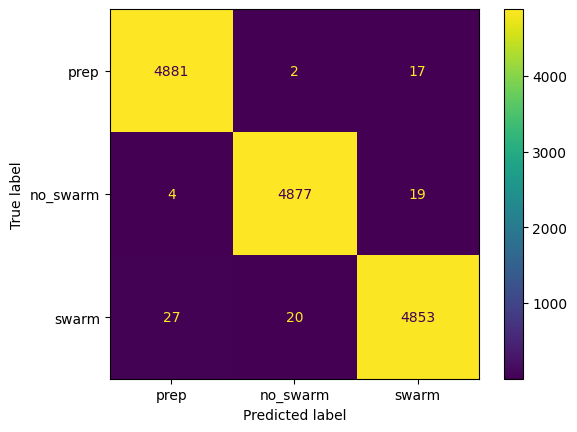

In [16]:
# Predict
y_pred = model.predict(X_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Inverse label encoding
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# Name of classes for confusion matrix display labels (-1: prep, 0: no_swarm, 1: swarm)
class_names = ['prep', 'no_swarm', 'swarm']

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

In [17]:
# model.save('/content/drive/MyDrive/chroma_cnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Hyperparameter Tuning